# Time Evolution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?
from gammapy.data import DataStore
from gammapy.irf import make_mean_psf
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import (
    MapDatasetMaker,
    PSFKernel,
    MapDataset,
    RingBackgroundMaker,
    SafeMaskMaker,
    #RingBackgroundEstimator,
)
from gammapy.modeling.models import (
    SkyModel,
    SkyModels,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    SkyDiffuseCube,
    TemplateSpatialModel,
    GaussianSpatialModel
)
from gammapy.stats import significance, excess # utiles ?

from gammapy.modeling import Fit
from astropy.time import Time

src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

import gammapy
gammapy.__version__

'0.15'

In [2]:
emin, emax = [0.5, 100] * u.TeV

energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 20, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    coordsys="GAL",
    proj="CAR",
)

energy_axis_true = MapAxis.from_bounds(
    0.3, 200, 30, unit="TeV", name="energy", interp="log"
)

In [3]:
from pathlib import Path

# Directory for outputs

path = Path("../../../../gammapy_data/GC_variability2020/hap-hd")
path.mkdir(exist_ok=True)

## Creating the datasets

In [4]:
mapdataset_dict = {}

for k in range (2004,2020):
    name = "map" + str(k)
    mapdataset_dict[k] = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name=name)

for year in range(2004,2020):
    
    filename = "mapdatasets/mapdataset" +str(year)+".fits.gz"
    mapdataset_dict[year] = MapDataset.read(path/filename)

## Reading the model template

In [5]:
name = path/"models/models_template.yaml"
modelGC,modelG09, modeldiff = SkyModels.read(name)

## Constructing the mask

In [6]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

bizarre_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([bizarre_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Applying the mask and the model template

In [7]:
for year in range(2004,2020):
    mapdataset_dict[year].fit_mask = fit_mask
    mapdataset_dict[year].models =  modelGC.copy() + modelG09.copy() +  modeldiff.copy()
    mapdataset_dict[year].background_model.parameters['norm'].value = 1.0

# Fitting the datasets

In [8]:
def fit_dataset(mapdataset):
    fit = Fit([mapdataset])
    result = fit.run()
    
    table = result.parameters.to_table()
    
    rescov = fit.covariance()
    ampSGRA = mapdataset.models.parameters[3]
    ampdiff = mapdataset.models.parameters[12]
    normbkg = mapdataset.background_model.parameters['norm']
    
    cov= rescov.parameters.get_subcovariance([ampSGRA, ampdiff, normbkg])
    
    return table, cov, result

In [9]:
%%time

results_per_year = dict()
results = []
cov_per_year = dict()


for year in range(2004,2020):
    
    table, cov, result = fit_dataset(mapdataset_dict[year])
    
    results.append(result)
    
    results_per_year[year] = table
    
    cov_per_year[year] = cov
    

CPU times: user 13min 41s, sys: 1min 12s, total: 14min 54s
Wall time: 14min 54s


In [10]:
years = range(2004,2020)

(<Figure size 432x288 with 1 Axes>,
 None)

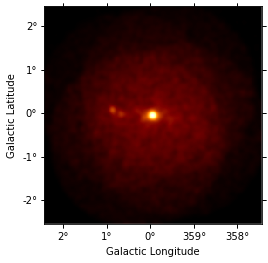

In [11]:
mapdataset_dict[2019].counts.sum_over_axes().cutout(src_pos,5*u.deg).smooth('0.05 deg').plot()

# Saving the results

## Model predictions

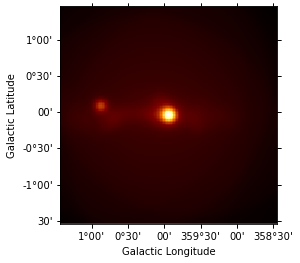

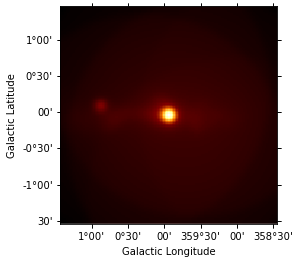

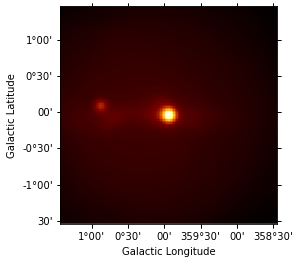

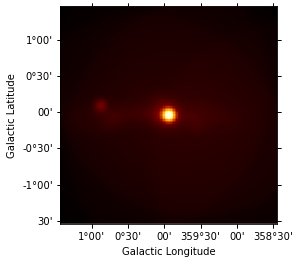

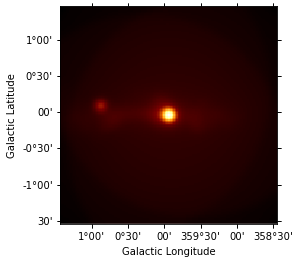

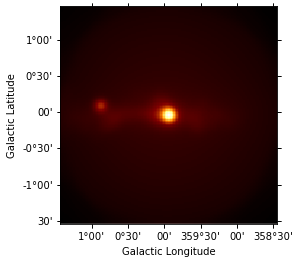

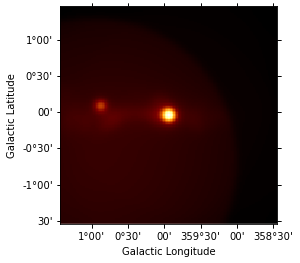

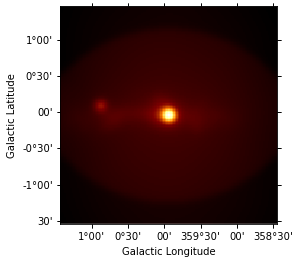

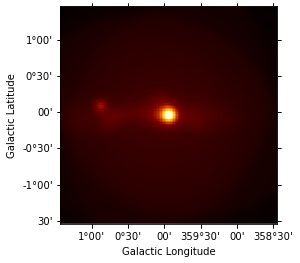

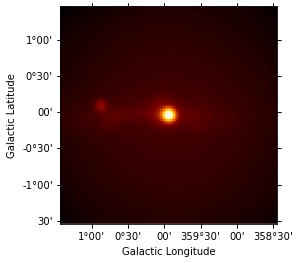

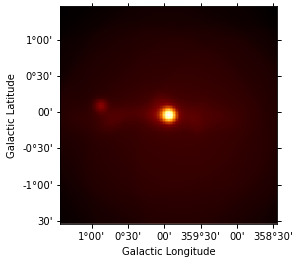

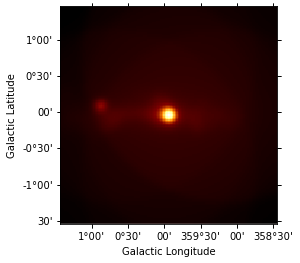

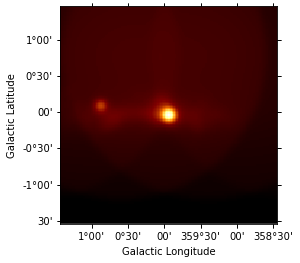

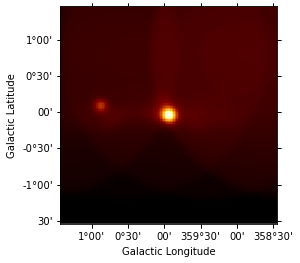

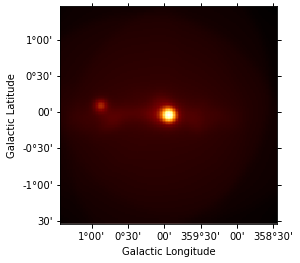

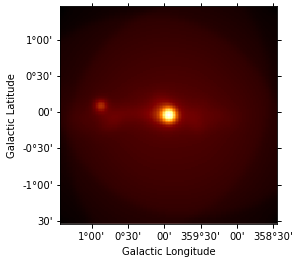

In [12]:
pathm = Path(path/"models/maps")
pathm.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    mapdataset_dict[year].npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
    name ="model_"+ str(year)+"_map.pdf"
    plt.savefig(pathm/name)

## Residuals

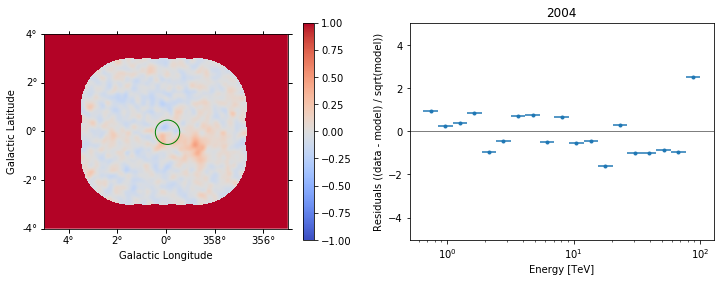

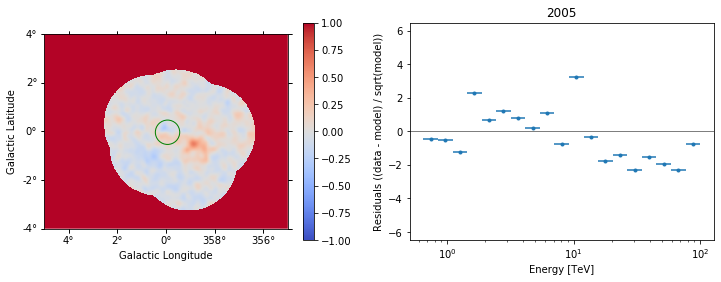

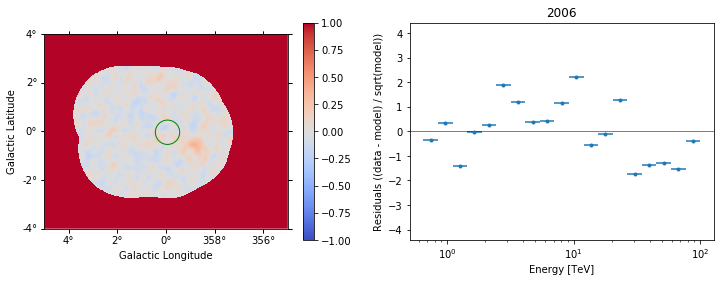

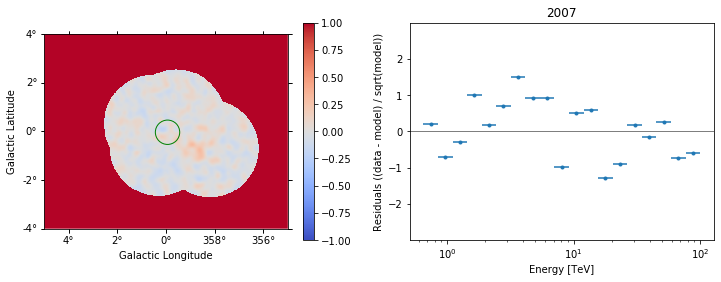

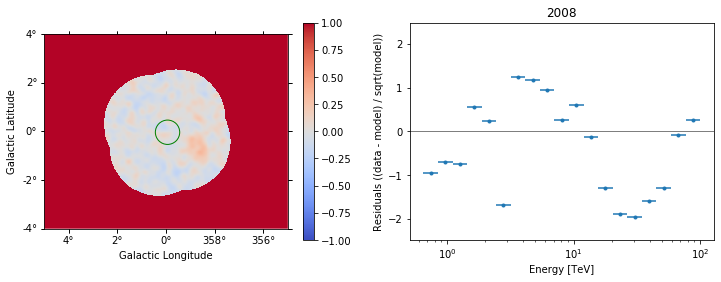

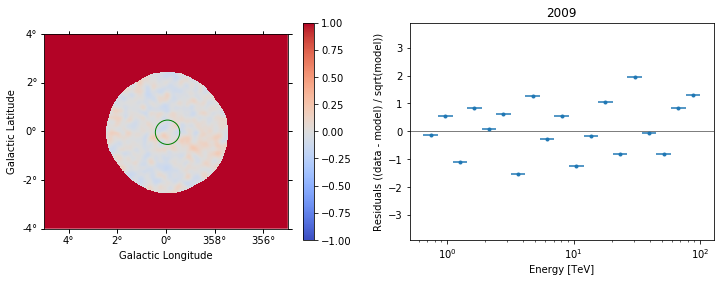

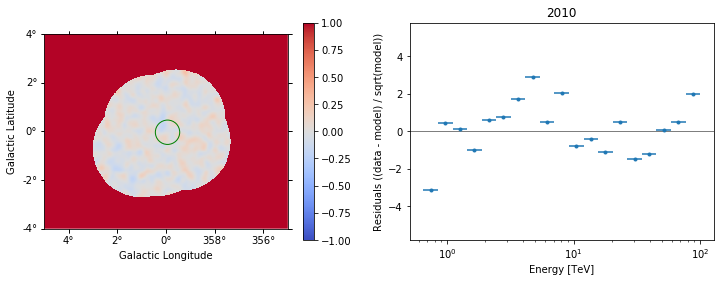

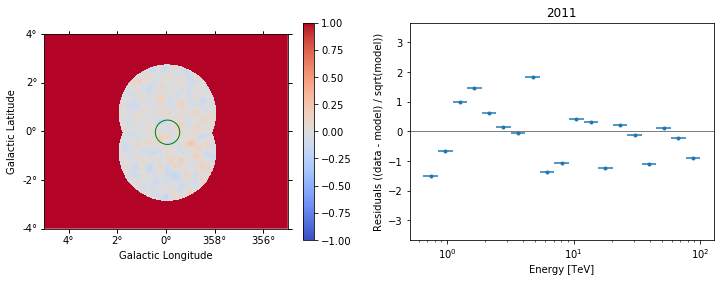

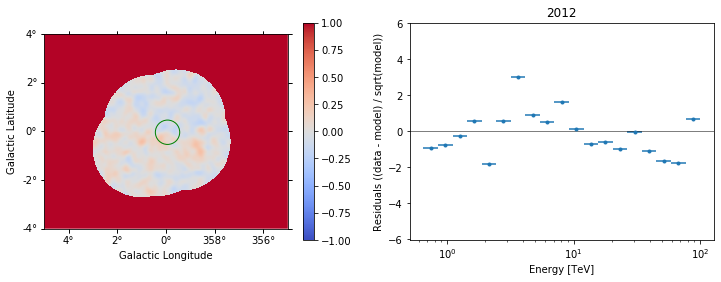

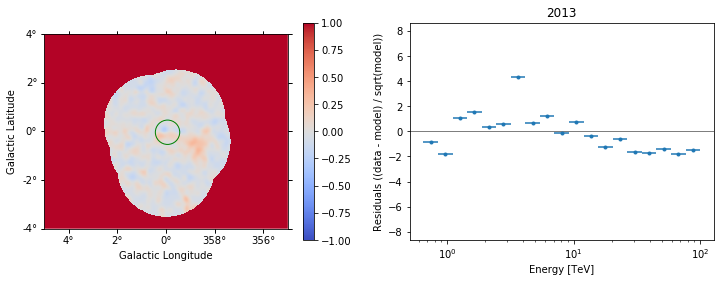

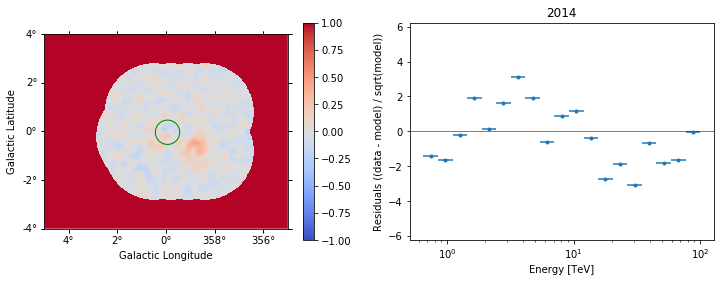

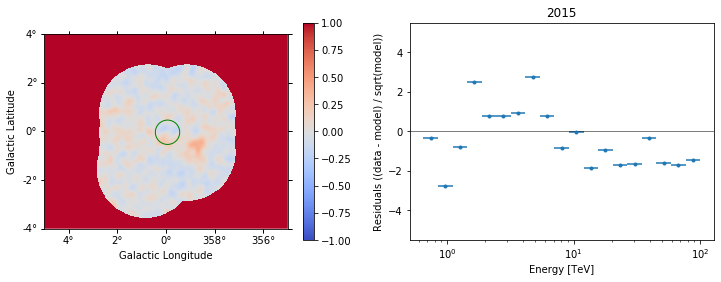

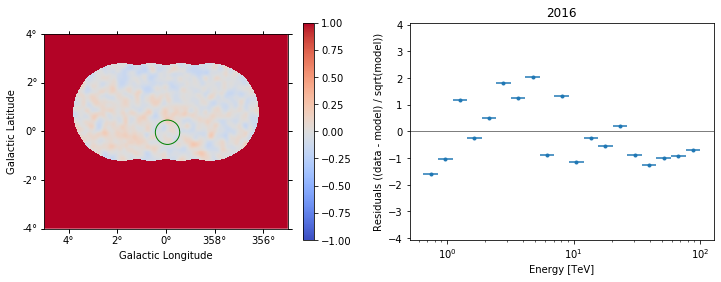

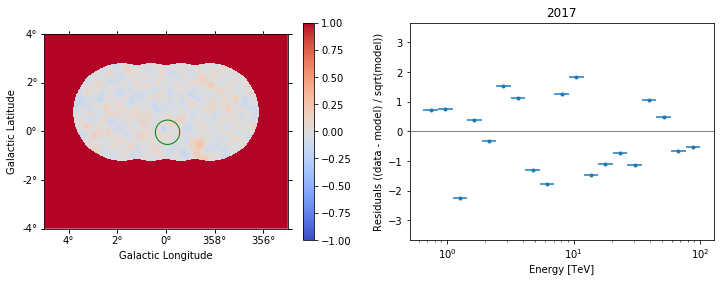

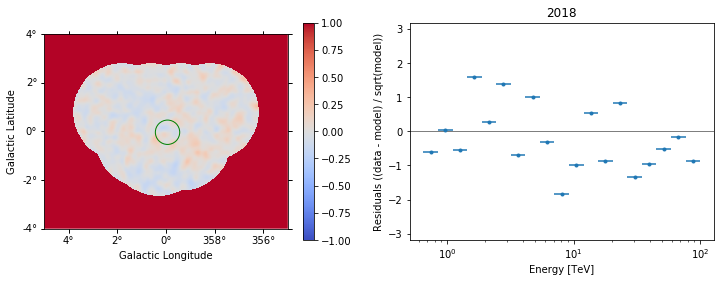

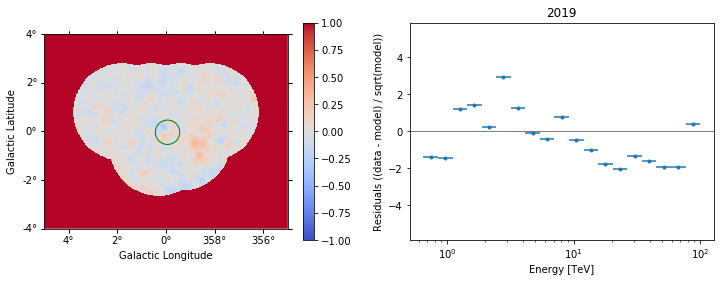

In [13]:
pathr = Path(path/"residuals")
pathr.mkdir(exist_ok=True)

region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

for year in years:
    mapdataset_dict[year].plot_residuals(
        region=region, method="diff/sqrt(model)", vmin=-1.0, vmax=1.0
        )
    name = "residuals_"+str(year)+".pdf"
    plt.title(str(year))
    plt.savefig(pathr/name, overwrite=True)

## Significance

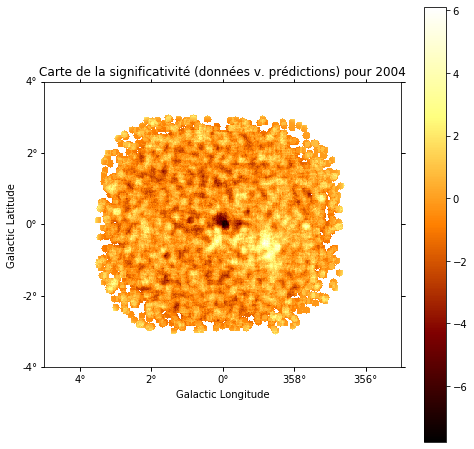

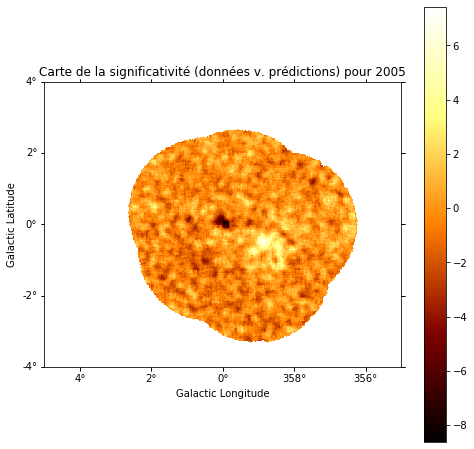

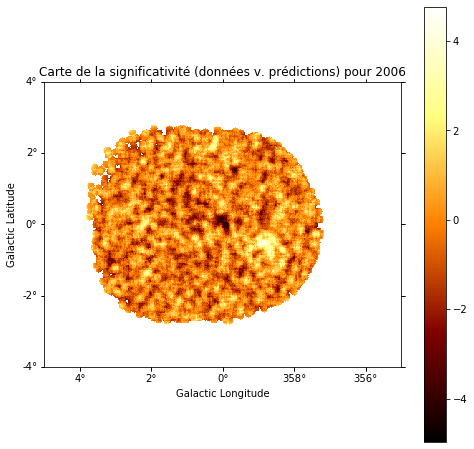

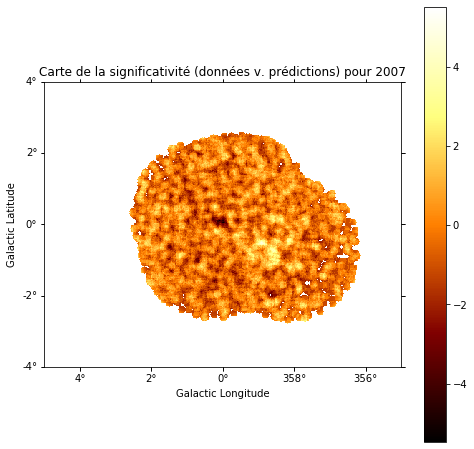

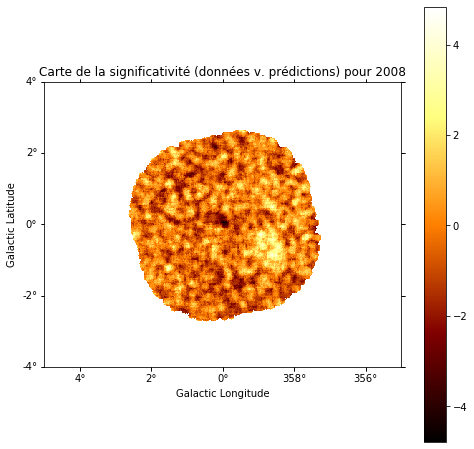

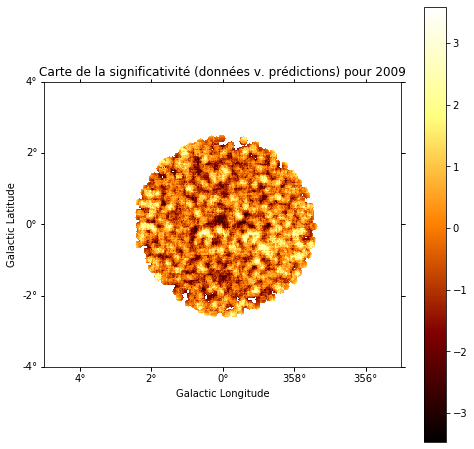

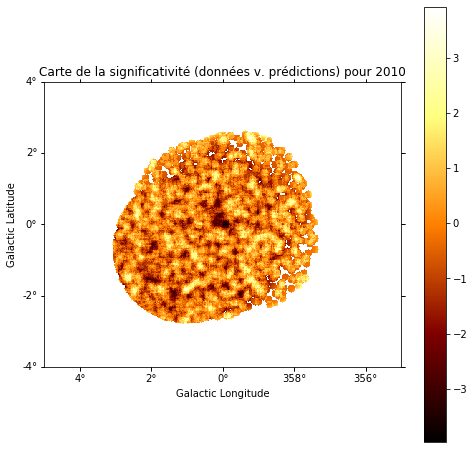

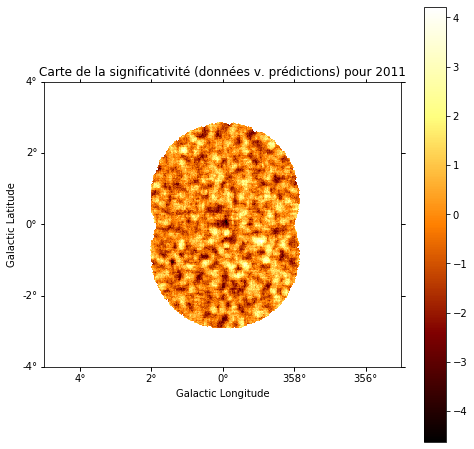

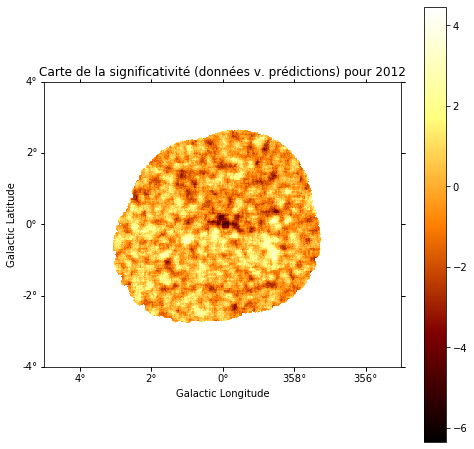

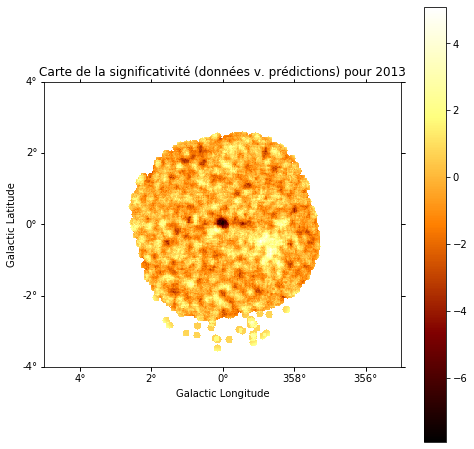

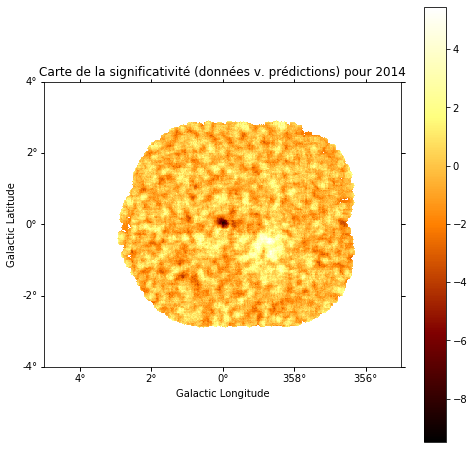

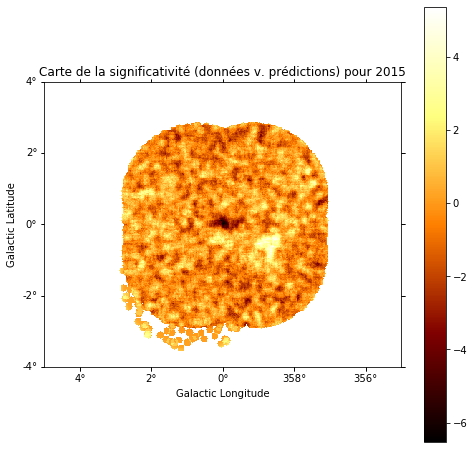

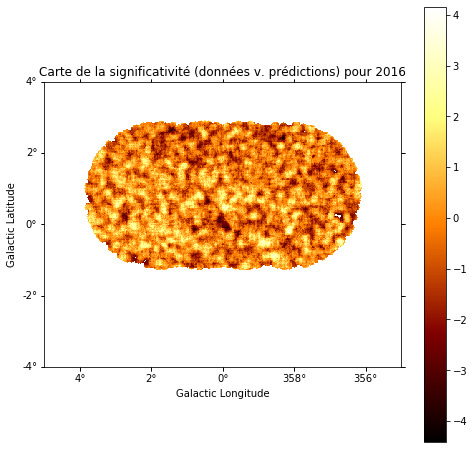

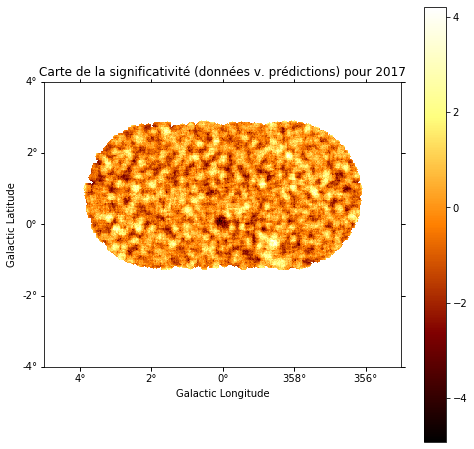

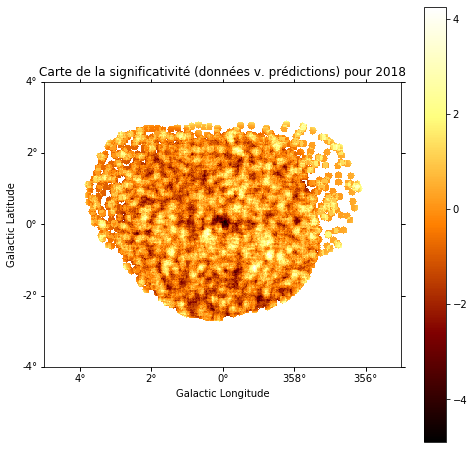

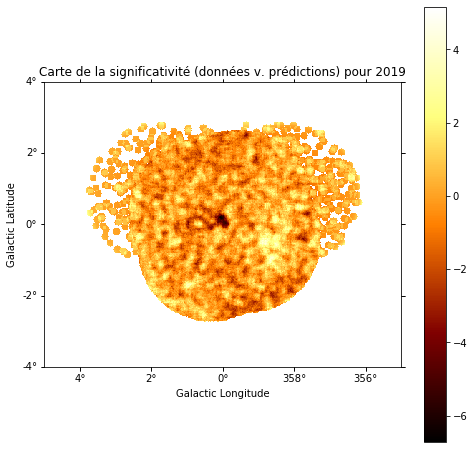

In [14]:
paths = Path(path/"significance")
paths.mkdir(exist_ok=True)

kernel = Tophat2DKernel(5) # il faut élargir la région où l'on compte les coups pour calculer la significativité, ici on prend 5 bin en distance angulaire par ex

lima_significances = dict()

for year in years:
    plt.figure(figsize=(8,8))
    counts = mapdataset_dict[year].counts.sum_over_axes()
    mod = mapdataset_dict[year].npred().sum_over_axes()
    lima_significances[year] = compute_lima_image(counts, mod, kernel)
    
    lima_significances[year]['significance'].plot(add_cbar=True)
    name = "significance_"+str(year)+".pdf"
    plt.title("Carte de la significativité (données v. prédictions) pour "+str(year))
    plt.savefig(paths/name, overwrite=True)

/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/home/samuel/anaconda3/envs/gammapy-0.15/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:897: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


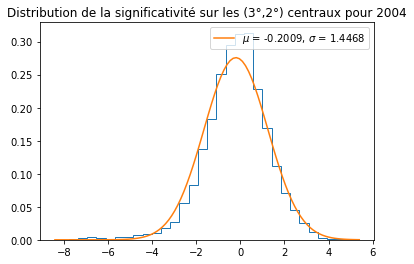

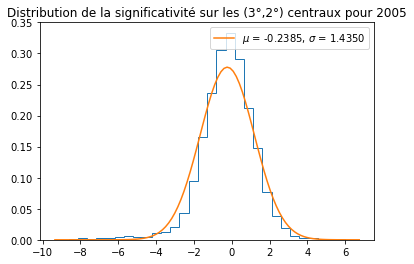

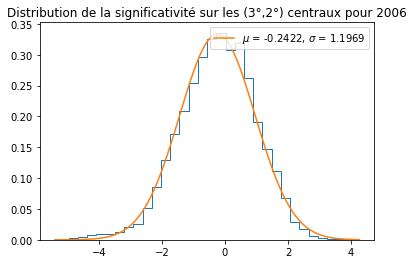

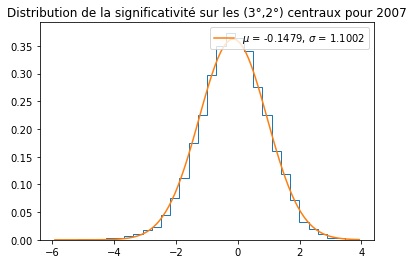

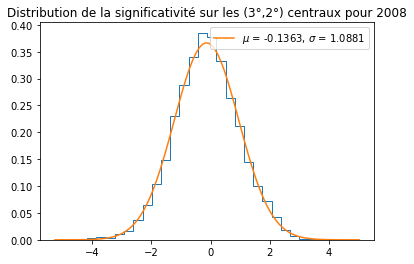

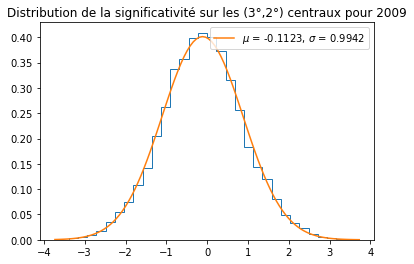

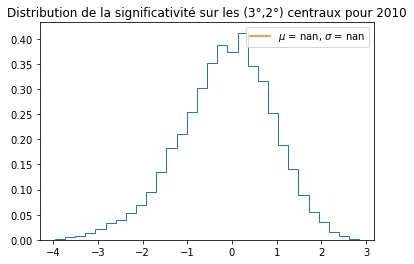

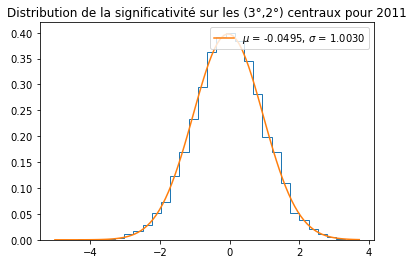

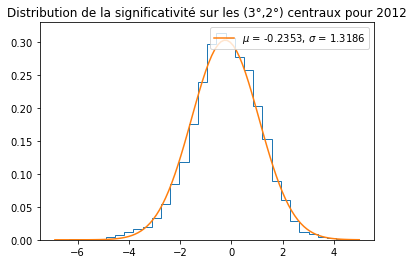

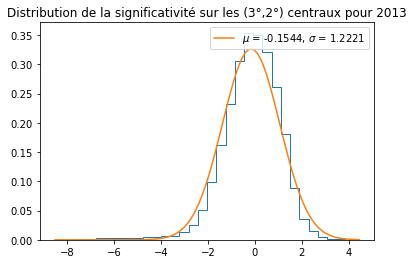

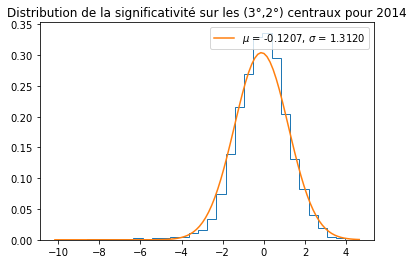

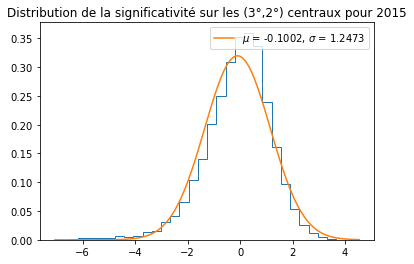

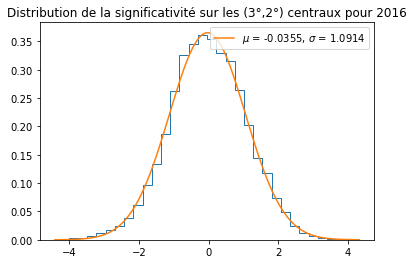

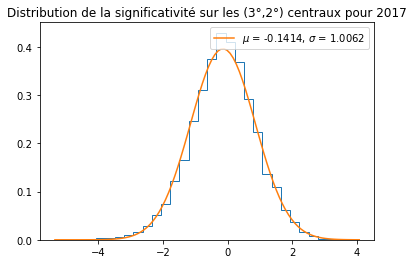

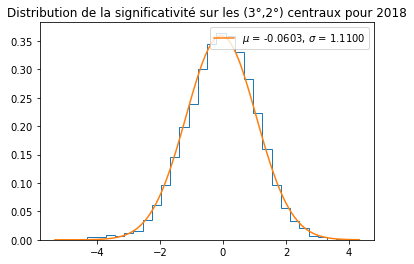

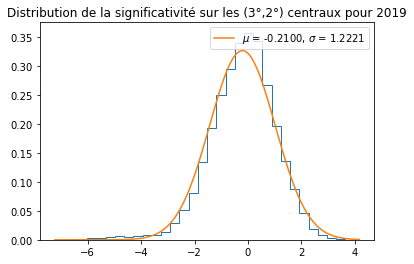

In [15]:
# on veut voir la distribution des significativité dans cette région (par ex)

from scipy.stats import norm

pathh = Path(paths/"significance_distrib")
pathh.mkdir(exist_ok=True)

for year in years:
    plt.figure()
    signidata = lima_significances[year]['significance'].cutout(position=src_pos, width=(3 * u.deg, 2* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 2 * u.deg)).data

    plt.hist(signidata[mask].flatten(),30, histtype='step', density=True)
    
    mean,std=norm.fit(signidata[mask])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    
    plt.legend(loc=1)
    
    name = "significance_hist"+str(year)+".pdf"
    plt.title("Distribution de la significativité sur les (3°,2°) centraux pour "+str(year))
    plt.savefig(pathh/name, overwrite=True)

## Time evolution of the fluxes

In [16]:
def CalculateFluxFromModels(year, emin, emax):
    GC_model, G09, DE_model  = mapdataset_dict[year].models
    
    amplitudeGC = results_per_year[year]['value'][3]
    amp_errGC = results_per_year[year]['error'][3]
    amplitudediff = results_per_year[year]['value'][12]
    amp_errdiff = results_per_year[year]['error'][12]

    norm = results_per_year[year]['value'][14]
    norm_err = results_per_year[year]['error'][14]

    if isinstance(emin, u.Quantity):
        #il faut convertir le flux du diffus qui est en sr-1, 
        # donc intégrer sur tout l'angle solide du template (opération inverse de celle effectuée par TamplateSpatialModel)
        
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)#*solid_angle_tot/u.sr  
        GC_flux = GC_model.spectral_model.integral(emin, emax)
        
    if np.isscalar(emin):
        emin = emin*u.TeV
        emax = emax*u.TeV
        diffuse_flux = DE_model.spectral_model.integral(emin, emax)
        GC_flux = GC_model.spectral_model.integral(emin, emax)
    
    return diffuse_flux, GC_flux, amplitudeGC, amp_errGC, amplitudediff, amp_errdiff, norm, norm_err

In [17]:
# Extracting parameters from each years fitted model

emin = 1.0*u.TeV
emax = 10*u.TeV
resGC = []
resdiff = []
ampsGC = []
amp_errsGC = []
ampsdiff = []
amp_errsdiff = []
norms = []
norms_err = []


for year in years:
    dif , GC, amp, amp_err, ampdiff, amp_errdiff, norm, norm_err = CalculateFluxFromModels(year, emin, emax)
    
    resGC.append(GC.value)
    resdiff.append(dif.value)
    ampsGC.append(amp)
    amp_errsGC.append(amp_err)
    ampsdiff.append(ampdiff)
    amp_errsdiff.append(amp_errdiff)
   
    
    norms.append(norm)
    norms_err.append(norm_err)
    
resGC = np.asarray(resGC)
ampsGC = np.asarray(ampsGC)
amp_errsGC = np.asarray(amp_errsGC)
resdiff = np.asarray(resdiff)
ampsdiff = np.asarray(ampsdiff)
amp_errsdiff = np.asarray(amp_errsdiff)
norms = np.asarray(norms)
norms_err = np.asarray(norms_err)

In [18]:
# Errors computation

yerrGC = (resGC/ampsGC)*amp_errsGC
yerrdiff = (resdiff/ampsdiff)*amp_errsdiff


cross_term = []
for k in range(len(years)):
    truc = 2*(cov_per_year[2004+k][0,1]*yerrGC[k]*yerrdiff[k])/(resGC[k]*resdiff[k])
    cross_term.append(truc)
      
yerr_rap = (resGC/resdiff)*np.sqrt((yerrGC/resGC)**2 + (yerrdiff/resdiff)**2 - cross_term )

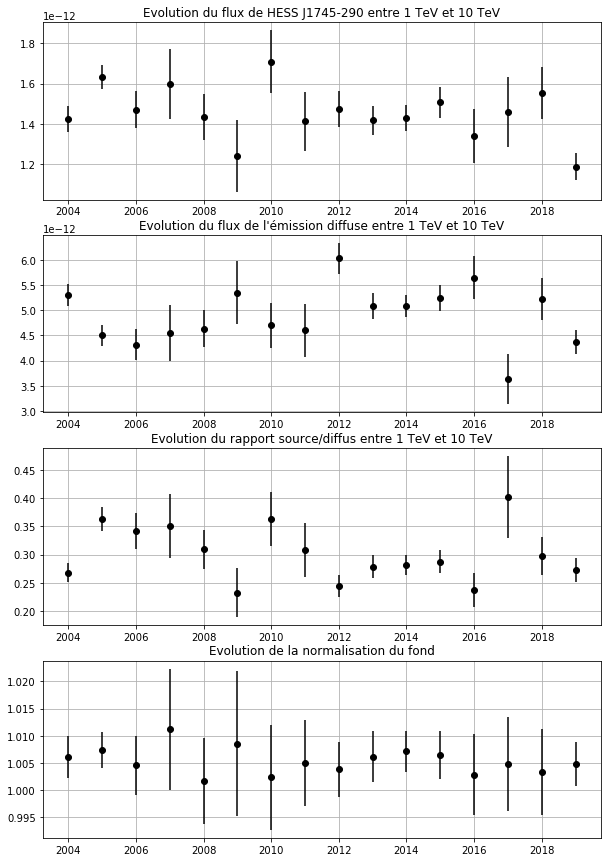

In [19]:
years = [k for k in range(2004,2020)]

plt.figure(figsize=(10,15))

ax1 = plt.subplot(4,1,1)

plt.errorbar(years , resGC, yerr=yerrGC, fmt='ko')# ax=ax1)
plt.title("Evolution du flux de HESS J1745-290 entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,2)
plt.errorbar(years , resdiff, yerr=yerrdiff, fmt='ko')
plt.title("Evolution du flux de l'émission diffuse entre 1 TeV et 10 TeV")
plt.grid()

ax2 = plt.subplot(4,1,3)
plt.errorbar(years , resGC/resdiff, yerr=yerr_rap, fmt='ko')
plt.title("Evolution du rapport source/diffus entre 1 TeV et 10 TeV")
plt.grid()


ax4 = plt.subplot(4,1,4)
plt.errorbar(years , norms, yerr=norms_err, fmt='ko')# ax=ax1)
plt.title("Evolution de la normalisation du fond")
plt.grid()

plt.savefig(path/"GCDEflux_evolution_04_19.pdf")

## Fitting a time evolution model

In [20]:
import scipy.stats as stats

from astropy.modeling import models, fitting

from scipy.stats import chisquare

# chi2 non réduit
def chisq(obs, exp, error):
    chisq = 0
    for i in range(len(obs)):
        chisq = chisq + ((obs[i]-exp)**2)/(error[i]**2)
    return chisq

# chi2 réduit
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp)**2)/(error[i]**2)
    return chisqr/(len(obs) -1)

#il y aurait un lien entre "survival function" aka la méthode sf, et la p-valeur, mais ce n'est pas clair


# ici on calcule le chi2 sans passer par les barres d'erreurs, est-ce que c'est vraimen ce qu'on veux ?
def TestStat(obs,exp, error):
    nddl = len(obs) -1
    chi2, pval = chisquare(obs,exp,nddl)
    return chi2/nddl, pval

### Evolution for the central source

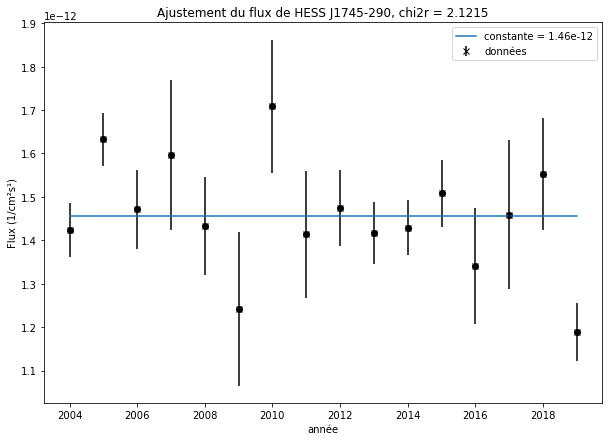

In [21]:
x = years
y = resGC
y_uncs = yerrGC


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-12)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y) #, weights=1.0/y_uncs)

# évaluation du chi2 réduit
A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(y, A2)
chi2r = chisqr(A1, A2, err_bars)

#pv = pval(A1, A2,err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Ajustement du flux de HESS J1745-290, chi2r = {0:03.4f}".format(chi2r))
plt.savefig(path/"fit_flux_SgrAstar_04_19_full.pdf")

### Evolution of the diffuse emission

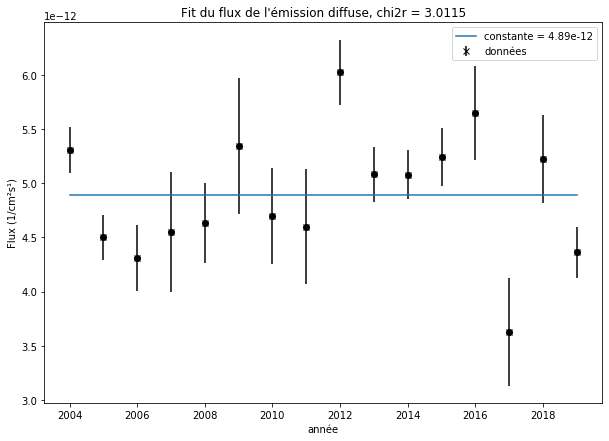

In [22]:
x = years
y = resdiff
y_uncs = yerrdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(1e-10)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y)#, weights=1.0/y_uncs)

A1 = y
A2 = t(2004)
err_bars = y_uncs
#chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)

#pv = pval(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=y_uncs, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 14)) )
plt.xlabel('année')
plt.ylabel('Flux (1/cm²s¹)')
plt.legend(loc=1)
plt.title("Fit du flux de l'émission diffuse, chi2r = {0:03.4f}".format(chi2r))
plt.savefig(path/"fit_flux_DE_04_19_full.pdf")

### Evolution of the ratio

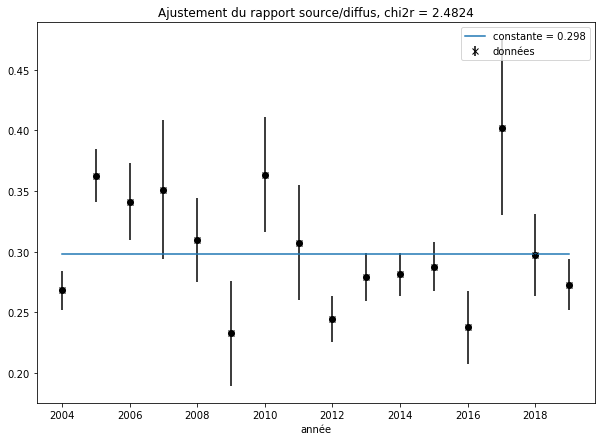

In [23]:
x = years
y = resGC/resdiff


# Fit the data using a box model.
# Bounds are not really needed but included here to demonstrate usage.
t_init = models.Const1D(0.6)
fit_t = fitting.LevMarLSQFitter()
t = fit_t(t_init, x, y, weights=1.0/y_uncs)


A1 = y
A2 = t(2004)
err_bars = yerr_rap
chi2, pval = stats.chisquare(A1, A2)
chi2r = chisqr(A1, A2, err_bars)


# Plot the data with the best-fit model
plt.figure(figsize=(10,7))
plt.plot(x, y, 'ko')
plt.errorbar(x, y, yerr=yerr_rap, fmt='kx', label="données")
plt.plot(x, t(x), label='constante = ' + str(round(t(2004), 3)) )
plt.xlabel('année')
plt.ylabel('')
plt.legend(loc=1)

plt.title("Ajustement du rapport source/diffus, chi2r = {0:03.4f}".format(chi2r))
plt.savefig(path/"fit_flux_GCsurDE_04_19_full.pdf")